In [1]:
import PIL.Image as Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import glob
from torchvision.models import AlexNet_Weights
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_df(path, classes=['dogs', 'cats']):
    paths = pd.DataFrame({'class': [], 'path': []})
    for c in classes:
        df = pd.DataFrame({
            'class': c,
            'path': glob.glob(path + c + '/*')
        })

        paths = pd.concat([paths, df])

    paths.reset_index(inplace=False)

    return paths

In [3]:
class MyDataset(Dataset):
    def __init__(self, df, classes, transform=None):
        self.paths = df
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        row = self.paths.iloc[idx]
        img = Image.open(row['path'])
        if self.transform is not None:
            return self.transform(img), self.classes[row['class']]
        else:
            return img, self.classes[row['class']]

In [4]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [5]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
EPOCHS = 10
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_TEST = 10
LR = 0.0001
LOG_INTERVAL = 100
RANDOM_SEED = 1
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
TRANSFORM = T.Compose([
    T.ToTensor(),
    T.Resize([224, 224]),
])

CLASSES = {'dogs': 0, 'cats': 1}

torch.manual_seed(RANDOM_SEED)

In [7]:
train_dataset = MyDataset(get_df('cats_and_dogs_filtered/train/'), CLASSES, TRANSFORM)
test_dataset = MyDataset(get_df('cats_and_dogs_filtered/validation/'), CLASSES, TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


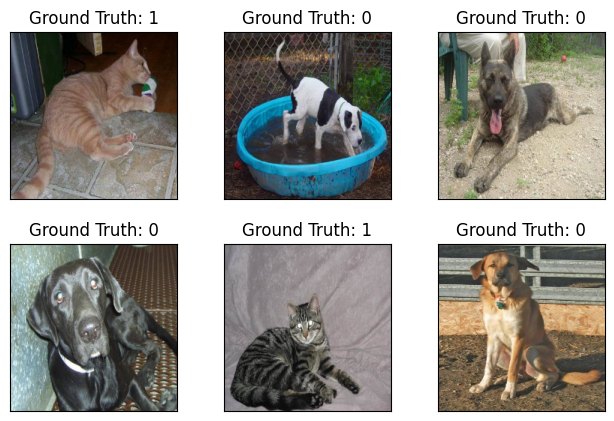

In [9]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(T.ToPILImage()(example_data[i]))
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights=AlexNet_Weights.DEFAULT)

Using cache found in /home/vi-b-04/.cache/torch/hub/pytorch_vision_v0.10.0


In [11]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    *model.classifier[:-1],
    nn.Linear(4096, 2, bias=True)
)

model = model.to(DEVICE)

In [13]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(EPOCHS + 1)]

In [16]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/2000 (0%)]	Loss: 0.880370
Train Epoch: 1 [1600/2000 (80%)]	Loss: 0.420382

Test set: Avg. loss: 0.0457, Accuracy: 808/1000 (81%)

Train Epoch: 2 [0/2000 (0%)]	Loss: 0.448909
Train Epoch: 2 [1600/2000 (80%)]	Loss: 0.344170

Test set: Avg. loss: 0.0382, Accuracy: 848/1000 (85%)

Train Epoch: 3 [0/2000 (0%)]	Loss: 0.721569
Train Epoch: 3 [1600/2000 (80%)]	Loss: 0.285765

Test set: Avg. loss: 0.0344, Accuracy: 859/1000 (86%)

Train Epoch: 4 [0/2000 (0%)]	Loss: 0.516029
Train Epoch: 4 [1600/2000 (80%)]	Loss: 0.265471

Test set: Avg. loss: 0.0320, Accuracy: 870/1000 (87%)

Train Epoch: 5 [0/2000 (0%)]	Loss: 0.283931
Train Epoch: 5 [1600/2000 (80%)]	Loss: 0.339777

Test set: Avg. loss: 0.0304, Accuracy: 882/1000 (88%)

Train Epoch: 6 [0/2000 (0%)]	Loss: 0.432147
Train Epoch: 6 [1600/2000 (80%)]	Loss: 0.457059

Test set: Avg. loss: 0.0291, Accuracy: 893/1000 (89%)

Train Epoch: 7 [0/2000 (0%)]	Loss: 0.322273
Train Epoch: 7 [1600/2000 (80%)]	Loss: 0.320038

Test set: Avg. loss

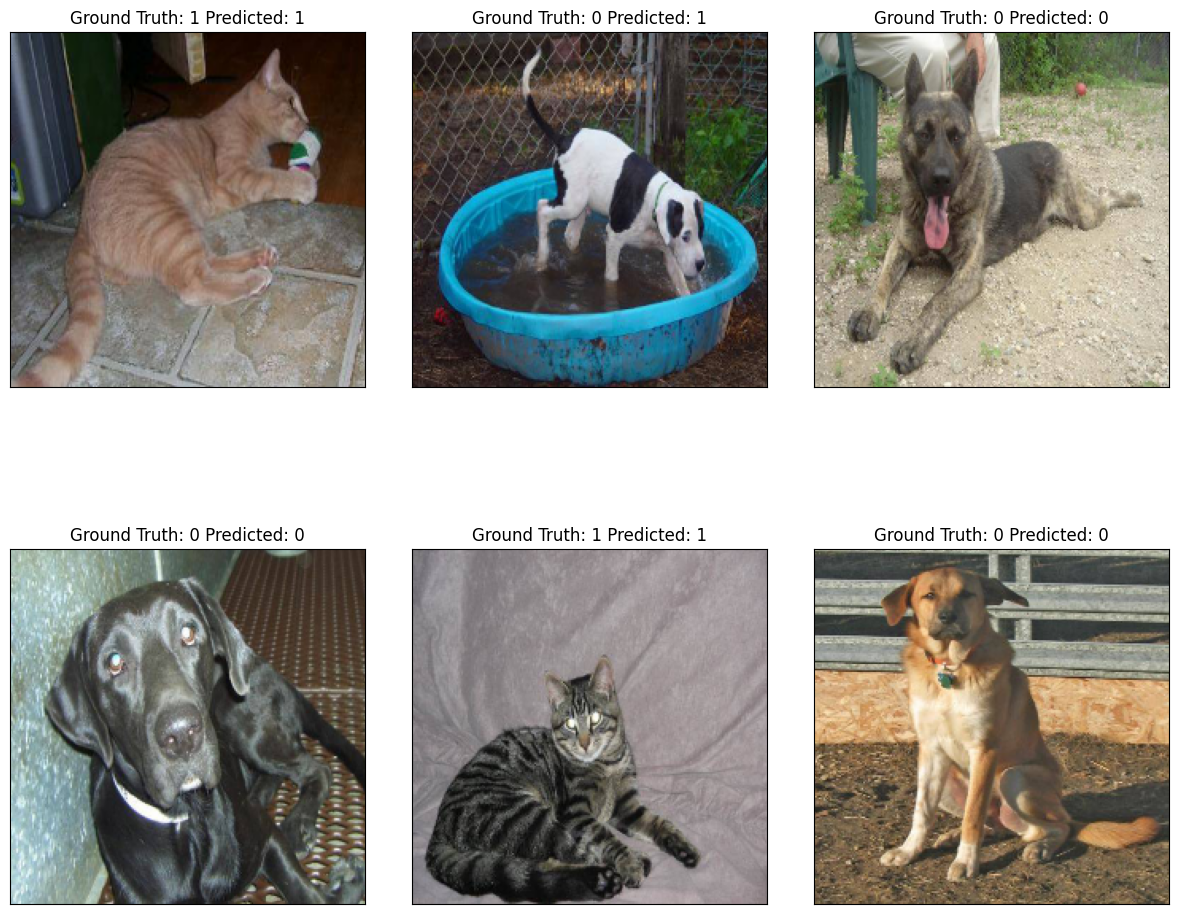

In [17]:
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(T.ToPILImage()(example_data[i]))
    output = model(example_data[i].unsqueeze(0))
    pred = output.data.max(1, keepdim=True)[1].item()
    plt.title("Ground Truth: {} Predicted: {}".format(example_targets[i], pred))
    plt.xticks([])
    plt.yticks([])

plt.show()